<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/covariance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* build intuition for what types of biological conclusions can be made from PCA, ie 3D map's covariance matrix (like cryoSPARC's 3DVA). Given a 3DVA result, what types of underlying structural dynamics can be concluded
* do simple problems in 2D (2DVA)

In [ ]:
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
def doplt(arr2d,cmap='gray',**kwargs): return(plt.imshow(arr2d,cmap=cmap,**kwargs))
from scipy.linalg import eigh

In [ ]:
!pip install pyfftw

     |████████████████████████████████| 2.6MB 10.2MB/s 


In [ ]:
!rm coords.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/transfer.py
!rm gauss_forward_model.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/gauss_forward_model.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/fourier.py

import coords, gauss_forward_model, transfer, fourier

--2021-04-22 12:11:06--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2483 (2.4K) [text/plain]
Saving to: ‘coords.py’

coords.py           100%[===================>]   2.42K  --.-KB/s    in 0s      

2021-04-22 12:11:06 (38.9 MB/s) - ‘coords.py’ saved [2483/2483]

--2021-04-22 12:11:06--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/transfer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2964 (2.9K) [text/p

# Resources
* Philippe Rigollet. (2017). MIT OpenCourseWare. 19. Principal Component Analysis. 
  * https://youtu.be/WW3ZJHPwvyg
  * https://youtu.be/a1ZCeFpeW0o

* Punjani, A., & Fleet, D. J. (2020). 3D Variability Analysis: Directly resolving continuous flexibility and discrete heterogeneity from single particle cryo-EM images. BioRxiv, 2020.04.08.032466. http://doi.org/10.1101/2020.04.08.032466

# Computing the covariance matrix

Let's ensure we know how to compute the covariance matrix. It's important that there is a fast way to compute it for many particles, each with a large number of dimensions ($N^2$ in the 2D case). 

Rigollet's lectures derive the equations used here. 

## 1D

In [ ]:
y = multivariate_normal(mean=1, cov=1)

In [ ]:
samples = y.rvs(size=100)

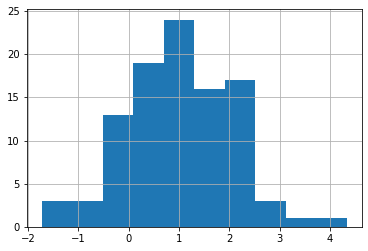

In [ ]:
pd.Series(samples).hist()

## 2D

In [ ]:
y = multivariate_normal(mean=[0,1], 
                        cov=np.array([[1,0],
                                     [0,10]]
                                     ))

In [ ]:
np.random.seed(0)
samples = y.rvs(size=1000)
samples.mean(0)

array([-0.00990328,  0.9312632 ])

(array([[ 0.,  0.,  0.,  1.,  1.,  3.,  3.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  3.,  2.,  3.,  2.,  2.,  1.,  0.],
        [ 0.,  1.,  7., 19., 20., 14.,  7.,  5.,  2.,  0.],
        [ 2.,  4., 10., 30., 40., 24., 18.,  8.,  2.,  1.],
        [ 0.,  6., 19., 37., 54., 43., 31., 14.,  3.,  2.],
        [ 0.,  9., 17., 44., 59., 57., 37., 17.,  5.,  2.],
        [ 3.,  2., 19., 22., 32., 38., 25., 12.,  3.,  0.],
        [ 2.,  2.,  7., 17., 22., 25., 14.,  4.,  1.,  0.],
        [ 0.,  1.,  7.,  9.,  8., 12.,  2.,  2.,  2.,  0.],
        [ 0.,  0.,  1.,  1.,  8.,  3.,  2.,  0.,  0.,  0.]]),
 array([-3.04614305, -2.46559324, -1.88504342, -1.3044936 , -0.72394379,
        -0.14339397,  0.43715585,  1.01770566,  1.59825548,  2.1788053 ,
         2.75935511]),
 array([-8.46979735, -6.52006735, -4.57033734, -2.62060734, -0.67087733,
         1.27885267,  3.22858267,  5.17831268,  7.12804268,  9.07777268,
        11.02750269]),
 <matplotlib.collections.QuadMesh at 0x7f1ce1aaf190>)

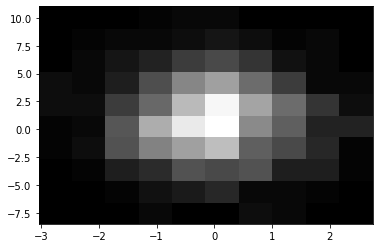

In [ ]:
plt.hist2d(samples[:,0],samples[:,1],cmap='gray')

Let's calculate the covariance matrix, element by element
$\sigma^2_{xy}=cov(x,y) = E\big[(x-E[x]) (y-E[y])\big] = 1/N\sum_{i=1}^N(x_i-E[x])(y_i-E[y])$

In [ ]:
N, d = samples.shape
cov = np.zeros((d,d))
for idx_r in range(d):
  for idx_c in range(d):
    if idx_c >= idx_r:
      x = samples[:,idx_r]
      y = samples[:,idx_c]
      Ex = x.mean()
      Ey = y.mean()
      cov_xy = ((x-Ex)*(y-Ey)).mean()
      cov[idx_r,idx_c] = cov_xy
      if idx_c != idx_r: cov[idx_c,idx_r] = cov_xy
cov

array([[ 0.96380469, -0.0421241 ],
       [-0.0421241 ,  9.49426557]])

Multidimensional case. 

Compare with formula
$$\Sigma_{jk} = \sigma_{ji}$$
$$\Sigma = E[XX^T] - E[X](E[X])^T$$

We compute this empirically (the sample covariance)
$$\bar X = N^{-1}\Sigma_{i=1}^N X_i$$
$$\Sigma = (N^{-1}\Sigma_{i=1}^N X_iX_i^T) - \bar X \bar X^T$$

Notice for this that we only have one loop over samples, and every samples contributes a $(d,d) $ that is independent from every other sample.


In [ ]:
Xbar = samples.mean(0)
cov_vec = np.zeros((d,d))
for i in range(N):
  Xi = samples[i]
  cov_vec += np.outer(Xi,Xi)
cov_vec /= N
cov_vec -= np.outer(Xbar,Xbar)

In [ ]:
cov_vec

array([[ 0.96380469, -0.0421241 ],
       [-0.0421241 ,  9.49426557]])

We can further vectorize things and remove the loop over samples:

$$\hat X = [\vec X_1 ... \vec X_N]^T$$
$$\bar X = N^{-1} \hat X^T \mathbb{1}$$

The data matrix also gives back the sum over the samples

$$\hat X \hat X^T = \Sigma_{i=1}^N X_iX_i^T$$

Thus 
$$
\Sigma = N^{-1}\hat X^T(I - N^{-1}\mathbb{1}\mathbb{1}^T)\hat X
$$

In [ ]:
def cov_matrix(samples,method=None,multidot=True):
  # multidot marginally faster
  # H method faster when d >> N, slower when d <= N
  N,d = samples.shape
  Xhat = samples
  ones_N = np.ones((N,N))
  if method == 'H' :
    H = np.eye(N) - ones_N/N
    if multidot:
      cov = multi_dot([Xhat.T,H,Xhat])
    else:
      cov = Xhat.T.dot(H).dot(Xhat) # only two dots. more efficient when d > N
  else:
    Xhat_t = Xhat.T
    if multidot:
      cov = Xhat_t.dot(Xhat) - multi_dot([Xhat_t,ones_N,Xhat])/N
    else:
      cov = Xhat_t.dot(Xhat) - Xhat_t.dot(ones_N).dot(Xhat)/N # three dots. more efficient when N > d
  cov /= N
  return(cov)
np.allclose(cov_matrix(samples,'H'),cov_matrix(samples))

True

In [ ]:
%timeit multi_dot([Xhat.T,ones_N,Xhat])
%timeit Xhat.T.dot(ones_N).dot(Xhat)

The slowest run took 7.27 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1.08 ms per loop
1000 loops, best of 5: 1.13 ms per loop


## Benchmark

For a 100 samples in a 10D space, let's benchmark how long this takes to run

In [ ]:
d=500
N=500
mean = np.zeros(d)
cov_gt = np.eye(d)
y = multivariate_normal(mean=mean,cov=cov_gt)
samples = y.rvs(size=N)

%timeit cov_matrix(samples,'H')
%timeit cov_matrix(samples,'H',multidot=False)
%timeit cov_matrix(samples)
%timeit cov_matrix(samples,multidot=False)

100 loops, best of 5: 11.9 ms per loop
100 loops, best of 5: 11.7 ms per loop
100 loops, best of 5: 15.3 ms per loop
100 loops, best of 5: 15.2 ms per loop


In [ ]:
d=1000
N=100
mean = np.zeros(d)
cov_gt = np.eye(d)
y = multivariate_normal(mean=mean,cov=cov_gt)
samples = y.rvs(size=N)

%timeit cov_matrix(samples,'H')
%timeit cov_matrix(samples,'H',multidot=False)
%timeit cov_matrix(samples)
%timeit cov_matrix(samples,multidot=False)

100 loops, best of 5: 6.04 ms per loop
100 loops, best of 5: 6.12 ms per loop
100 loops, best of 5: 12.4 ms per loop
100 loops, best of 5: 12.3 ms per loop


In [ ]:
d=100
N=1000
mean = np.zeros(d)
cov_gt = np.eye(d)
y = multivariate_normal(mean=mean,cov=cov_gt)
samples = y.rvs(size=N)

%timeit cov_matrix(samples,'H')
%timeit cov_matrix(samples,'H',multidot=False)
%timeit cov_matrix(samples)
%timeit cov_matrix(samples,multidot=False)

100 loops, best of 5: 8.95 ms per loop
100 loops, best of 5: 9.16 ms per loop
100 loops, best of 5: 6.86 ms per loop
100 loops, best of 5: 6.93 ms per loop


In [ ]:
def cov_features(samples):
  N,d = samples.shape
  cov = np.zeros((d,d))
  for idx_r in range(d):
    for idx_c in range(d):
      if idx_c >= idx_r:
        x = samples[:,idx_r]
        y = samples[:,idx_c]
        Ex = x.mean()
        Ey = y.mean()
        cov_xy = ((x-Ex)*(y-Ey)).mean()
        cov[idx_r,idx_c] = cov_xy
        if idx_c != idx_r: cov[idx_c,idx_r] = cov_xy
  return(cov)
np.allclose(cov_features(samples),cov_matrix(samples))

True

In [ ]:
def cov_samples(samples):
  N,D = samples.shape
  Xbar = samples.mean(0)
  cov_vec = np.zeros((d,d))
  for i in range(N):
    Xi = samples[i]
    cov_vec += np.outer(Xi,Xi)
  cov_vec /= N
  cov_vec -= np.outer(Xbar,Xbar)
  return(cov_vec)
np.allclose(cov_samples(samples),cov_matrix(samples))

True

In [ ]:
%timeit cov_features(samples) # mor eefficient with less dimensions
%timeit cov_samples(samples) # more efficient when less samples
%timeit cov_matrix(samples) # more efficient when less samples, more efficient than cov_samples
%timeit cov_matrix(samples,'H') # more efficient when less samples, more efficient than cov_samples

# 2DVA
In the 2D case, there is actually many more dimensions than 2. Each pixel is a dimension, with its value given by the intensity. So there are $d=N^2$ dimensions. In real cases we'll have $d = N^2 \sim 256^2 = 65536 \sim n_{particles}$

## two gaussian blobs (uniform)
$$A \sim Uniform[0,1]$$
$$B = A-1$$
$$X = A\exp(-|\vec r - \vec r_1|^2 /(2\sigma^2)) + B\exp(-|\vec r - \vec r_2|^2 /(2\sigma^2))$$

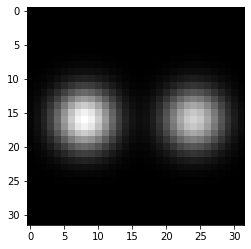

In [ ]:
n_particles = 100
N=32
coords_1d = np.arange(-N//2,N//2)
xv,yv = np.meshgrid(coords_1d,coords_1d)
sigma=3
projs = np.zeros((n_particles,N,N))
np.random.seed(0)
a_s = np.random.uniform(low=0,high=1,size=n_particles)
for idx in range(n_particles):
  projs[idx] = a_s[idx]*gauss_forward_model.make_gauss_2d(xv,yv,mu=[-N//4,0],sigma=sigma)
  projs[idx] += (1-a_s[idx])*gauss_forward_model.make_gauss_2d(xv,yv,mu=[+N//4,0],sigma=sigma)
doplt(projs[0])

In [ ]:
samples = projs.reshape(n_particles,-1)
%time sample_var = cov_matrix(samples,'H')

CPU times: user 21.1 ms, sys: 5.03 ms, total: 26.1 ms
Wall time: 18.9 ms


In [ ]:
d=N*N
evals, evecs = eigh(sample_var,eigvals=[d-3,d-1]) #evecs (dxk), so evecs[:,0] is the first evector

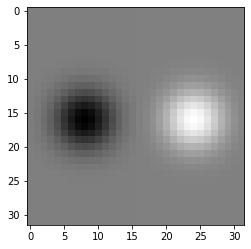

In [ ]:
doplt(evecs[:,-1].reshape(N,N))

Here there is only one principal component that captures the variation. It's linear in the sense that it's a number associated with each pixel, and they do not "talk to each other" through cross terms, etc

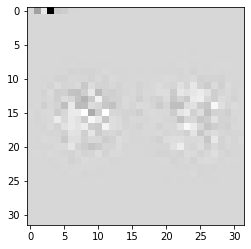

In [ ]:
doplt(evecs[:,-2].reshape(N,N))

The other components have very small evalues and look noisy

Let's see how the particles are distributed on the principal components

In [ ]:
pcs = evecs.T.dot(samples.T)

Text(0.5, 1.0, '2DVA: two Gaussian blobs with uniform intensity')

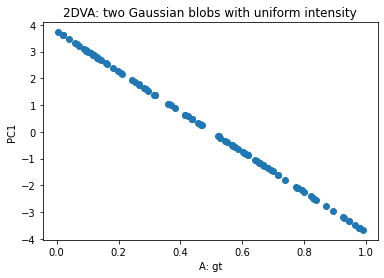

In [ ]:
plt.scatter(x=a_s,y=pcs[-1])
plt.xlabel('A: gt')
plt.ylabel('PC1')
plt.title('2DVA: two Gaussian blobs with uniform intensity')

Text(0.5, 1.0, '2DVA: two Gaussian blobs with uniform intensity \n')

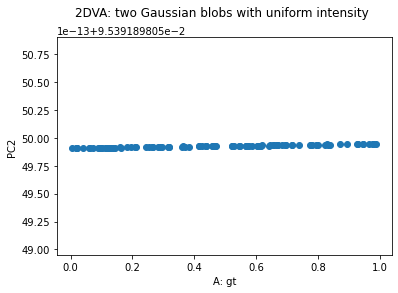

In [ ]:
plt.scatter(x=a_s,y=pcs[-2])
plt.xlabel('A: gt')
plt.ylabel('PC2')
plt.title('2DVA: two Gaussian blobs with uniform intensity \n')

## two gaussian blobs (Bernoulli)
$$A \sim U[0,1]$$
$$B = A-1$$
$$X = A\exp(-|\vec r - \vec r_1|^2 /(2\sigma^2)) + B\exp(-|\vec r - \vec r_2|^2 /(2\sigma^2))$$

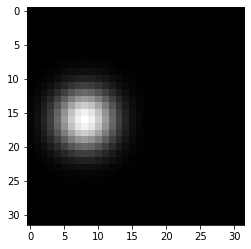

In [ ]:
n_particles = 100
N=32
coords_1d = np.arange(-N//2,N//2)
xv,yv = np.meshgrid(coords_1d,coords_1d)
sigma=3
projs = np.zeros((n_particles,N,N))
np.random.seed(0)
a_s = np.random.binomial(n=1,p=.5,size=n_particles)
for idx in range(n_particles):
  projs[idx] = a_s[idx]*gauss_forward_model.make_gauss_2d(xv,yv,mu=[-N//4,0],sigma=sigma)
  projs[idx] += (1-a_s[idx])*gauss_forward_model.make_gauss_2d(xv,yv,mu=[+N//4,0],sigma=sigma)
doplt(projs[0])

In [ ]:
samples = projs.reshape(n_particles,-1)
%time sample_var = cov_matrix(samples,'H')

CPU times: user 21.9 ms, sys: 5 ms, total: 26.9 ms
Wall time: 23.8 ms


In [ ]:
d=N*N
evals, evecs = eigh(sample_var,eigvals=[d-3,d-1]) #evecs (dxk), so evecs[:,0] is the first evector

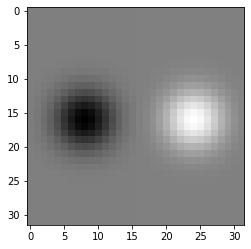

In [ ]:
doplt(evecs[:,-1].reshape(N,N))

In [ ]:
pcs = evecs.T.dot(samples.T)

In [ ]:
plt.scatter(x=a_s,y=pcs[-1])
plt.xlabel('A: gt')
plt.ylabel('PC1')
plt.title('2DVA: two Gaussian blobs with Bernoulli intensity')

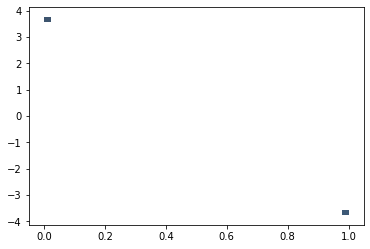

In [ ]:
import seaborn as sns
sns.histplot(x=a_s, y=pcs[-1], bins=50)

We see that even thought the same eigen image is the same, the way the particles project is totally different: the gradual spread from the uniform case, and the other from the Bernoulli. 

The Bernoulli case looks like there's only two points, but this is because all there are two types of identical particles (no noise)

With noise these will spread out. Let's take a look now... 

## one Gaussian blob with displacement

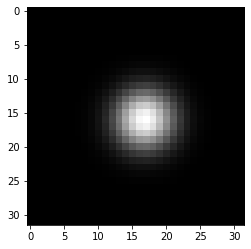

In [ ]:
n_particles = 1000
N=32
coords_1d = np.arange(-N//2,N//2)
xv,yv = np.meshgrid(coords_1d,coords_1d)
sigma=3
projs = np.zeros((n_particles,N,N))
np.random.seed(0)
mu_s = np.random.uniform(low=-N//4,high=N//4,size=n_particles)
for idx in range(n_particles):
  projs[idx] = gauss_forward_model.make_gauss_2d(xv,yv,mu=[mu_s[idx],0],sigma=sigma)
doplt(projs[0])

In [ ]:
sigma_noise = .1
# projs_noise = np.random.normal(loc=projs,scale=sigma_noise)
samples = projs.reshape(n_particles,-1)
sample_var = cov_matrix(samples,'H')
k=10
evals, evecs = eigh(sample_var,eigvals=[d-k,d-1]) 


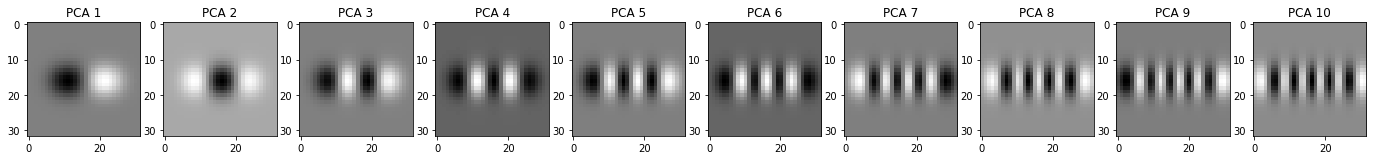

In [ ]:
fig,axes = plt.subplots(ncols=k,figsize=(24,12))
for k_idx in range(k):
  axes[k_idx].imshow(evecs[:,-k_idx-1].reshape(N,N),cmap='gray') ; axes[k_idx].set_title('PCA %i'%(k_idx+1))

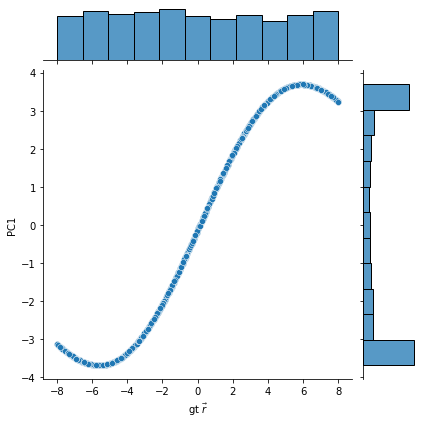

In [ ]:
pcs = evecs.T.dot(samples.T)
xlab = r'gt $\vec r$'
ylab = 'PC1'
df = pd.DataFrame({xlab:mu_s,ylab:pcs[-1]})
ax = sns.jointplot(x=xlab,y=ylab,data=df)


This displacement case is problematic for PCA. If we would only see the distribution along PC1, we could take subsets of particles along them and confound different areas along the gt rection coordinate.

Depending on the PC component, this effect is minimal. PC1 separates the displacement well, but higher PC values do not.

For instance, let's look at what the average image is like if we subset out particles along different PCAs. This makes sense in the discrete case where there are two main clusters along a PCA.

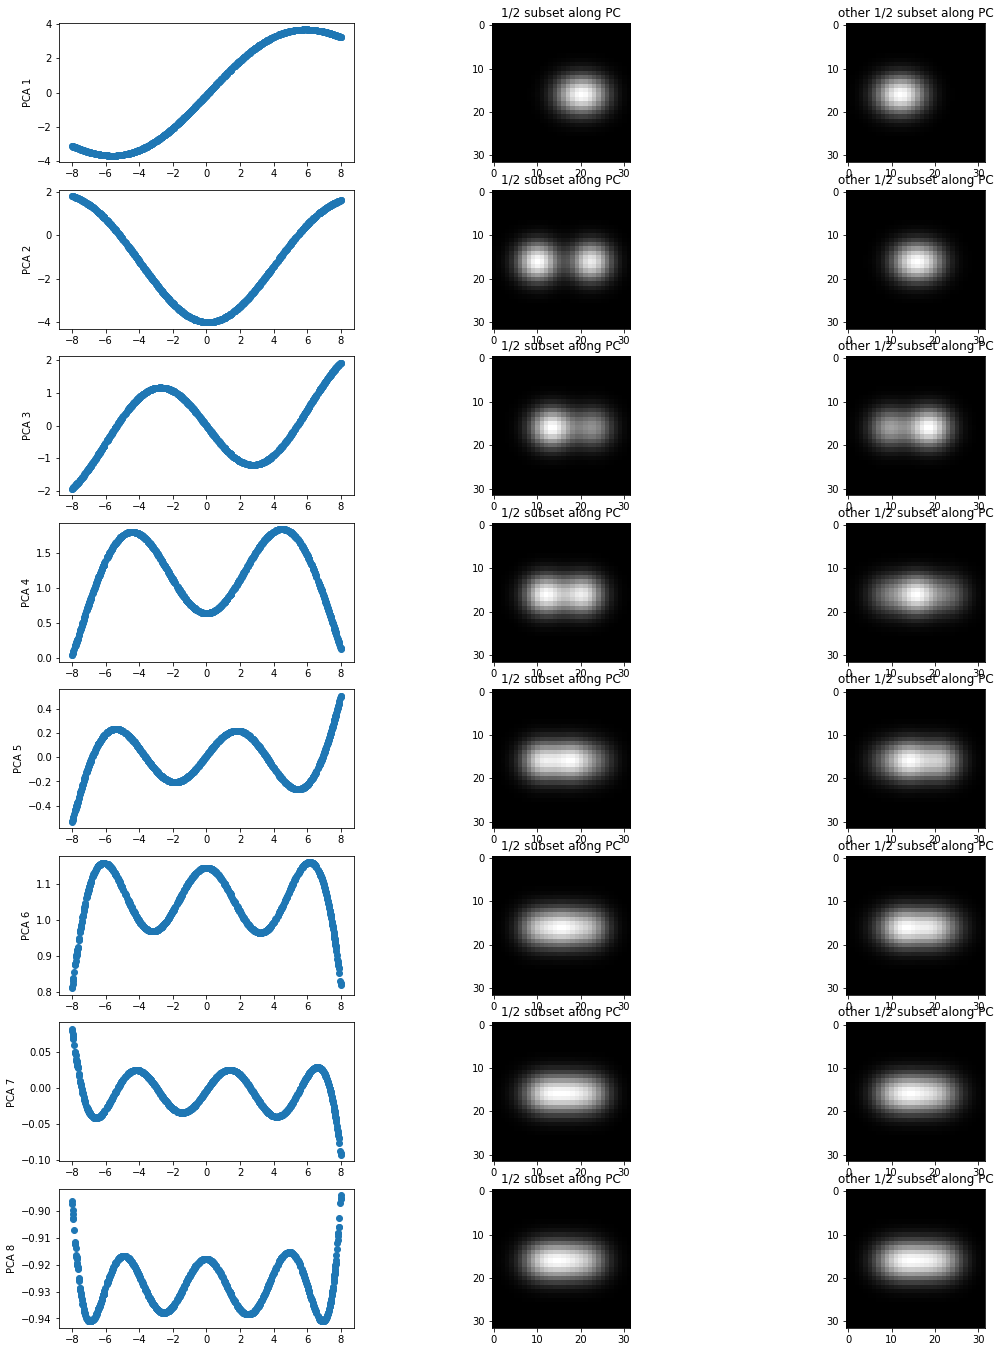

In [265]:
idx_subset = pcs > pcs.mean(1).reshape(-1,1)
fig,axes = plt.subplots(ncols=3,nrows=k,figsize=(18,24))

for k_idx in range(k):
  subset_particles0 = (samples[idx_subset[-k_idx-1]]).mean(0).reshape(N,N)
  subset_particles1 = (samples[~idx_subset[-k_idx-1]]).mean(0).reshape(N,N)
  
  axes[k_idx,0].scatter(x=mu_s,y=pcs[-k_idx-1]) ; axes[k_idx,0].set_ylabel('PCA %i'%(k_idx+1))
  axes[k_idx,1].imshow(subset_particles0,cmap='gray') ; axes[k_idx,1].set_title('1/2 subset along PC')
  axes[k_idx,2].imshow(subset_particles1,cmap='gray') ; axes[k_idx,2].set_title('other 1/2 subset along PC')

In the continuous case, it isn't a good idea to subset into two groups... instead let's visualize "movies" along each PCA.

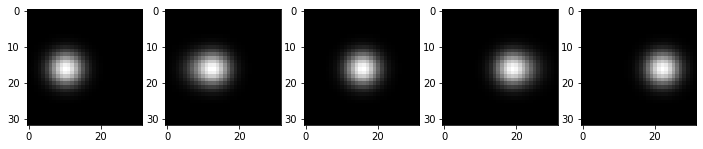

In [245]:
sorted_idx = np.argsort(pcs[-1,:])
n_frames = 5
split_idxs = np.array_split(np.arange(n_particles), n_frames)
fig,axes = plt.subplots(ncols=n_frames,figsize=(12,36))

for plot_idx, split_idx in enumerate(split_idxs):
  frame = samples[sorted_idx][split_idx].mean(0).reshape(N,N)
  axes[plot_idx].imshow(frame,cmap='gray')

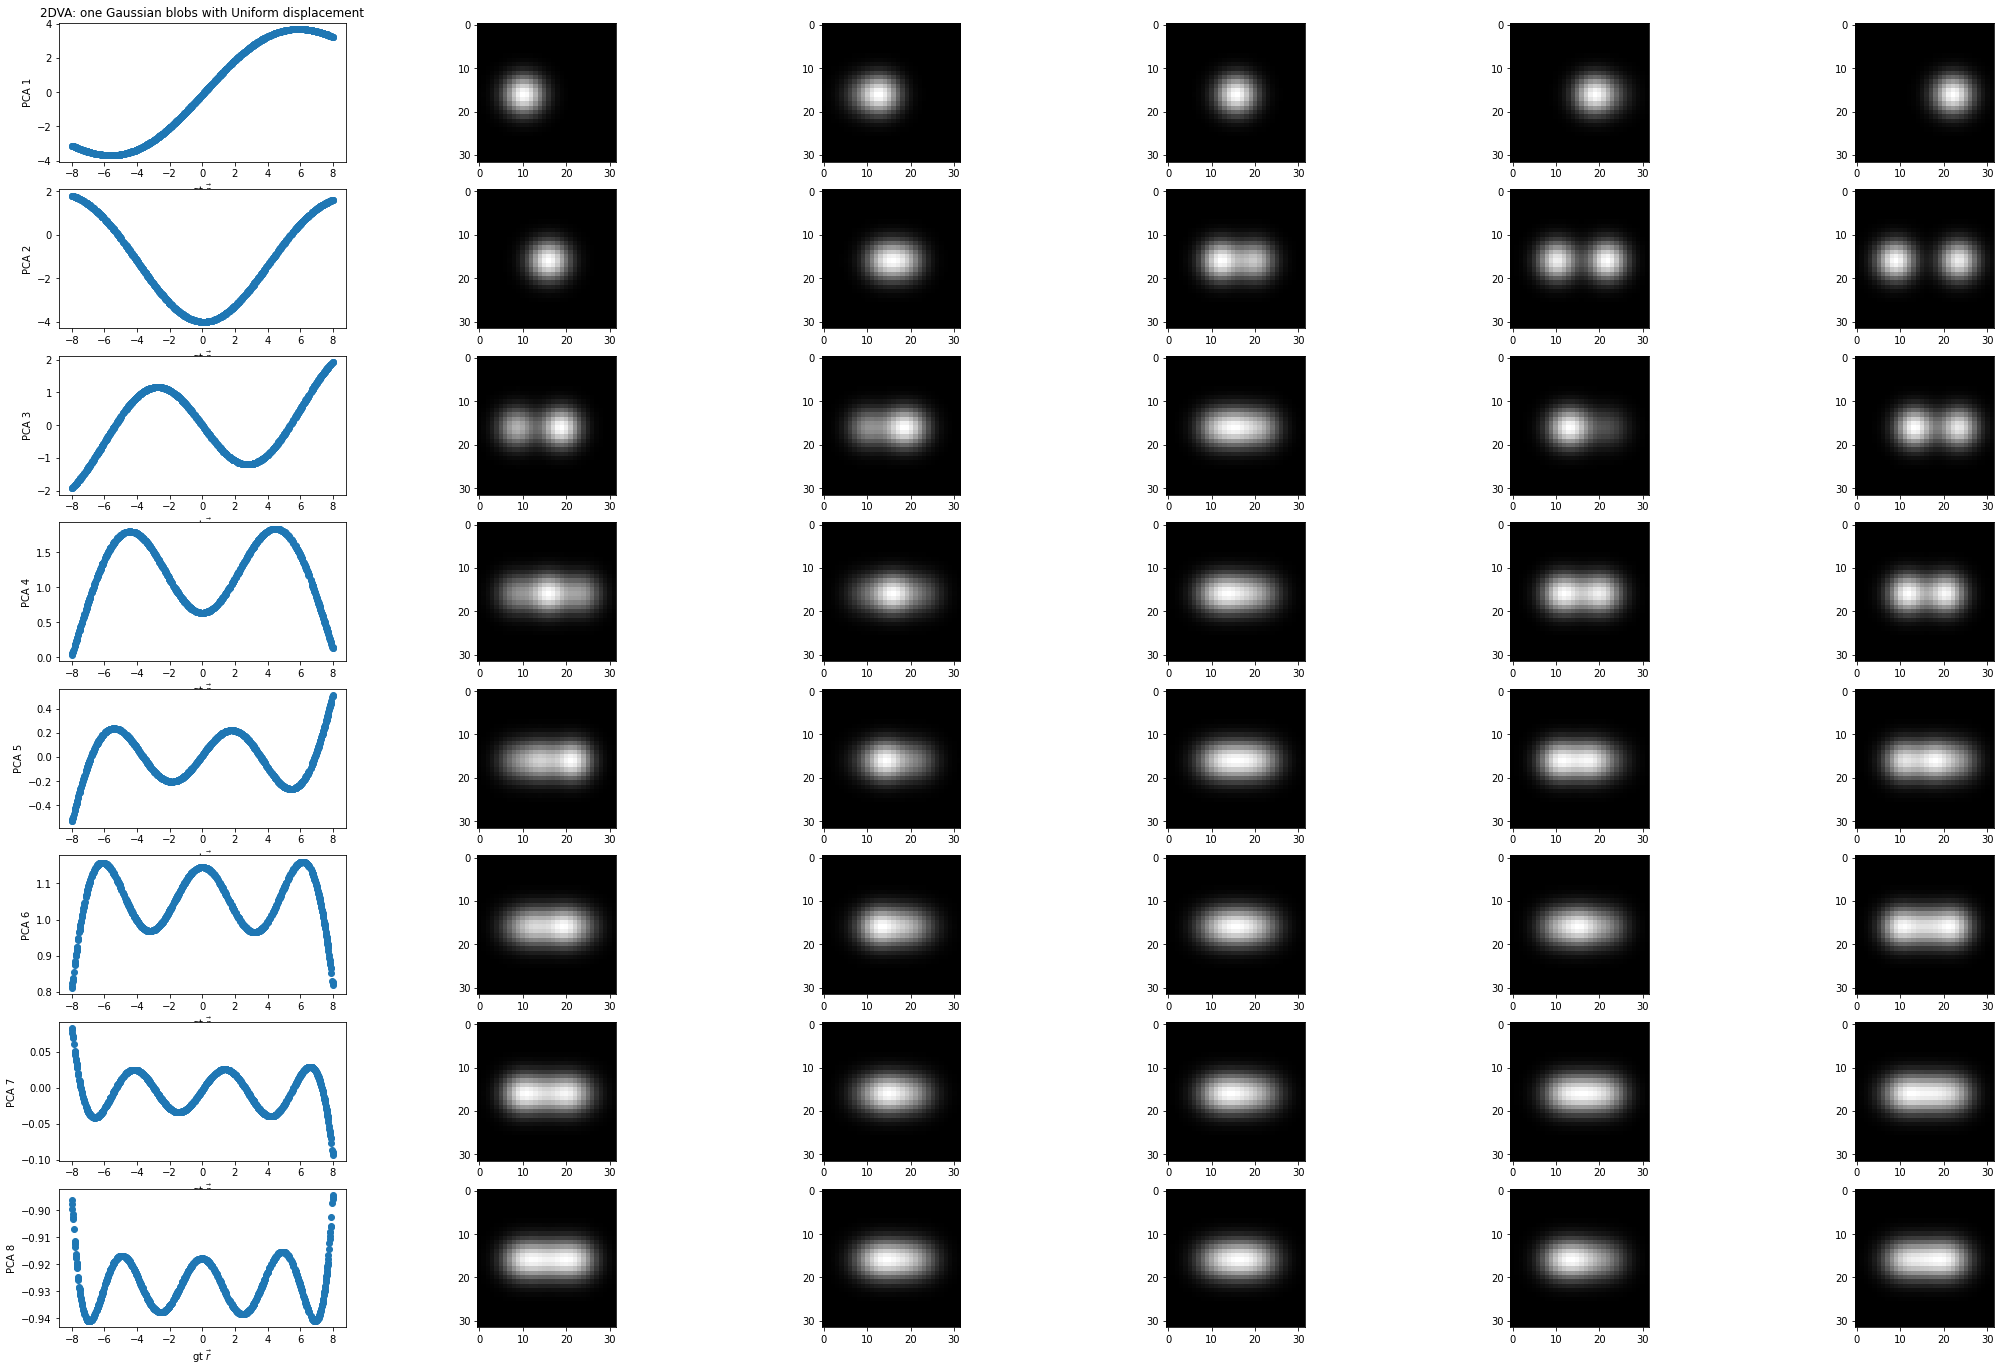

In [252]:
n_frames = 5
split_idxs = np.array_split(np.arange(n_particles), n_frames)

k=8
pcs = evecs.T.dot(samples.T)
idx_subset = pcs > pcs.mean(1).reshape(-1,1)
fig,axes = plt.subplots(nrows=k,ncols=1+n_frames,figsize=(36,24))
for k_idx in range(k):
  axes[k_idx,0].scatter(x=mu_s,y=pcs[-k_idx-1])
  if k_idx == 0:
    axes[k_idx,0].set_title('2DVA: one Gaussian blobs with Uniform displacement')
  axes[k_idx,0].set_ylabel('PCA %i'%(k_idx+1))
  axes[k_idx,0].set_xlabel(r'gt $\vec r$')

  sorted_idx = np.argsort(pcs[-k_idx-1,:])
  for plot_idx, split_idx in enumerate(split_idxs):
    frame = samples[sorted_idx][split_idx].mean(0).reshape(N,N)
    axes[k_idx,1+plot_idx].imshow(frame,cmap='gray')


Here we see that the first PCA captures the underlying ground truth heterogenity, but the other PCAs do not.

# Gaussian blobs with noise

## Uniform

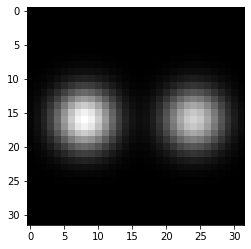

In [ ]:
n_particles = 100
N=32
coords_1d = np.arange(-N//2,N//2)
xv,yv = np.meshgrid(coords_1d,coords_1d)
sigma=3
projs = np.zeros((n_particles,N,N))
np.random.seed(0)
# a_s = np.random.binomial(n=1,p=.5,size=n_particles)
a_s = np.random.uniform(low=0,high=1,size=n_particles)

for idx in range(n_particles):
  projs[idx] = a_s[idx]*gauss_forward_model.make_gauss_2d(xv,yv,mu=[-N//4,0],sigma=sigma)
  projs[idx] += (1-a_s[idx])*gauss_forward_model.make_gauss_2d(xv,yv,mu=[+N//4,0],sigma=sigma)
doplt(projs[0])

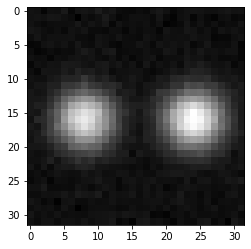

In [ ]:
sigma_noise = .1
projs_noise = np.random.normal(loc=projs,scale=sigma_noise)
doplt(projs_noise.sum(0))

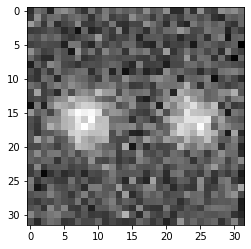

In [ ]:
doplt(projs_noise[0])

We can get a sense of the noise by comparing the average (like an aligned 2D class with a single particle)

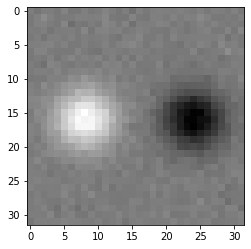

In [ ]:
samples = projs_noise.reshape(n_particles,-1)
sample_var = cov_matrix(samples,'H')
evals, evecs = eigh(sample_var,eigvals=[d-3,d-1]) 
doplt(evecs[:,-1].reshape(N,N))

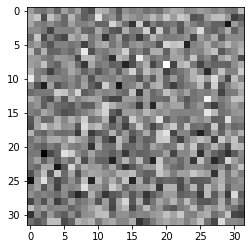

In [ ]:
doplt(evecs[:,-2].reshape(N,N))

In [ ]:
pcs = evecs.T.dot(samples.T)

Text(0.5, 1.0, '2DVA: two Gaussian blobs with uniform intensity')

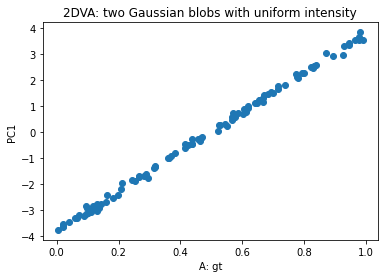

In [ ]:
plt.scatter(x=a_s,y=pcs[-1])
plt.xlabel('A: gt')
plt.ylabel('PC1')
plt.title('2DVA: two Gaussian blobs with uniform intensity')

## Bernoulli

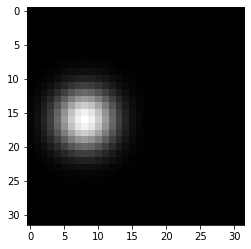

In [ ]:
n_particles = 100
N=32
coords_1d = np.arange(-N//2,N//2)
xv,yv = np.meshgrid(coords_1d,coords_1d)
sigma=3
projs = np.zeros((n_particles,N,N))
np.random.seed(0)
a_s = np.random.binomial(n=1,p=.5,size=n_particles)
for idx in range(n_particles):
  projs[idx] = a_s[idx]*gauss_forward_model.make_gauss_2d(xv,yv,mu=[-N//4,0],sigma=sigma)
  projs[idx] += (1-a_s[idx])*gauss_forward_model.make_gauss_2d(xv,yv,mu=[+N//4,0],sigma=sigma)
doplt(projs[0])

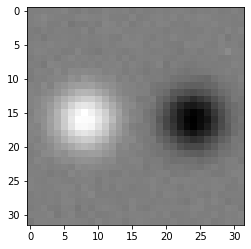

In [ ]:
sigma_noise = .1
projs_noise = np.random.normal(loc=projs,scale=sigma_noise)
samples = projs_noise.reshape(n_particles,-1)
sample_var = cov_matrix(samples,'H')
evals, evecs = eigh(sample_var,eigvals=[d-3,d-1]) 
doplt(evecs[:,-1].reshape(N,N))

Text(0.5, 1.0, '2DVA: two Gaussian blobs with Bernoulli intensity')

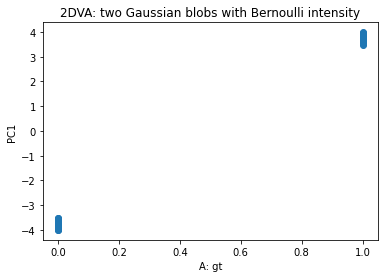

In [ ]:
pcs = evecs.T.dot(samples.T)
plt.scatter(x=a_s,y=pcs[-1])
plt.xlabel('A: gt')
plt.ylabel('PC1')
plt.title('2DVA: two Gaussian blobs with Bernoulli intensity')

In [ ]:
# sns.scatterplot(x=a_s, y=pcs[-1],s=30,x_jitter=1)
# sns.jointplot(x=a_s, y=pcs[-1], kind="hex")


Even wtih noise, they still project to very much the same location on PC1

# Interesting biological example